In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from scipy import stats
from scipy.stats import norm, skew

warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
print(train.shape)
print(test.shape)

(1460, 81)
(1459, 80)


There are numerical features and categorical features in the data

# 1.Feature Preprocessing

## 1a. Outliers

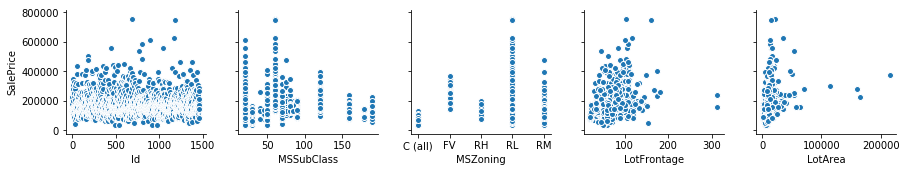

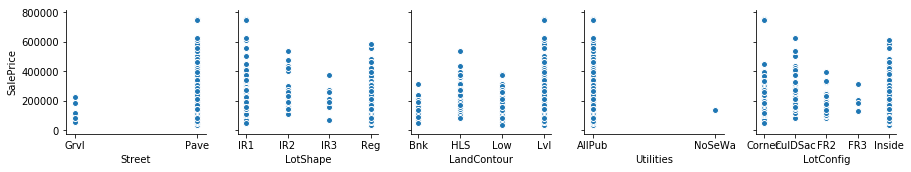

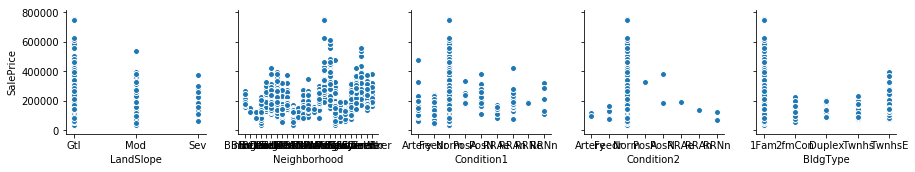

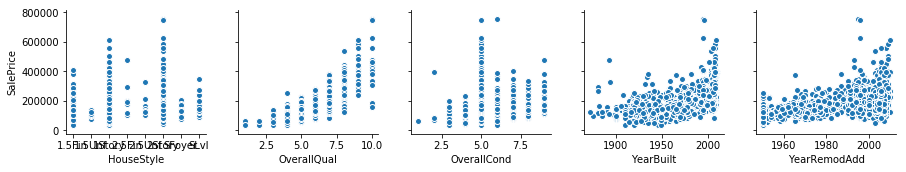

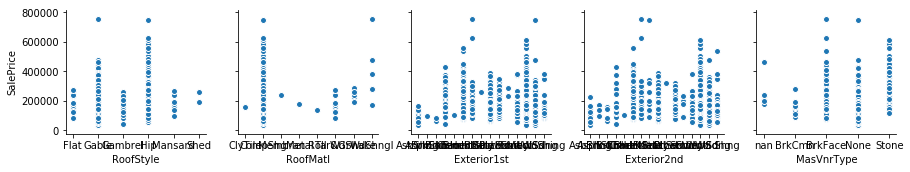

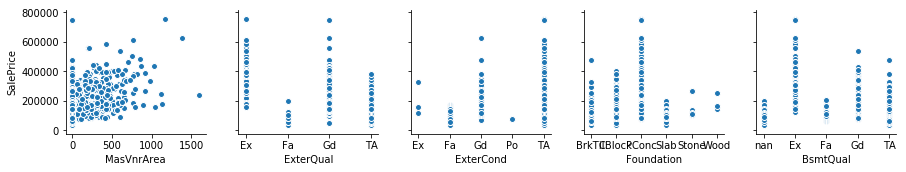

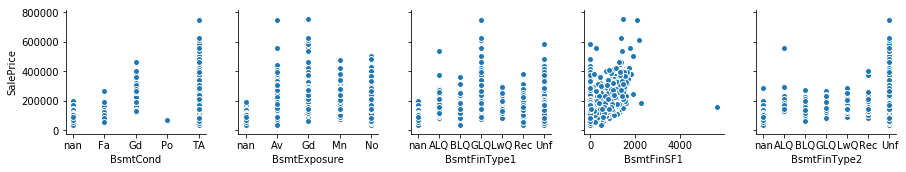

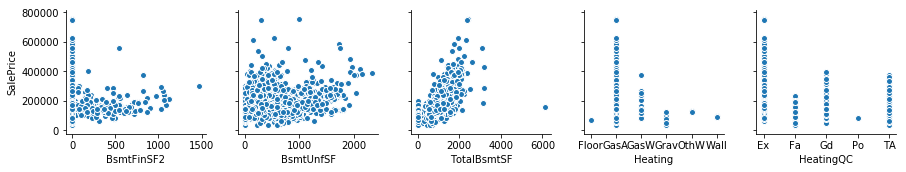

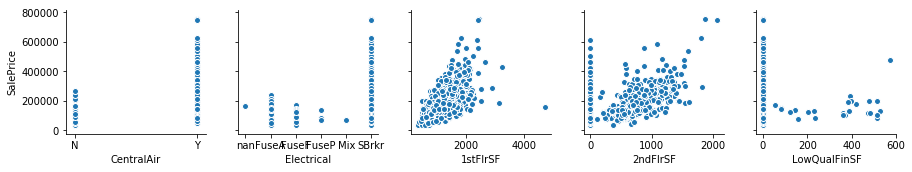

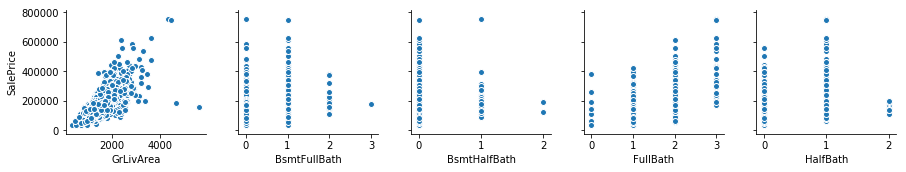

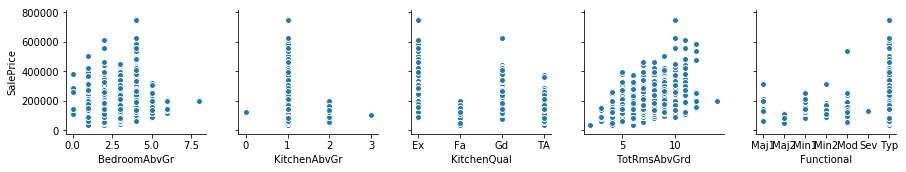

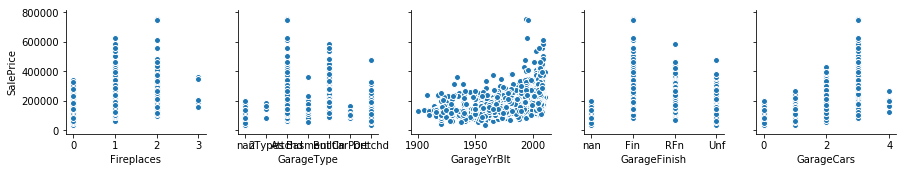

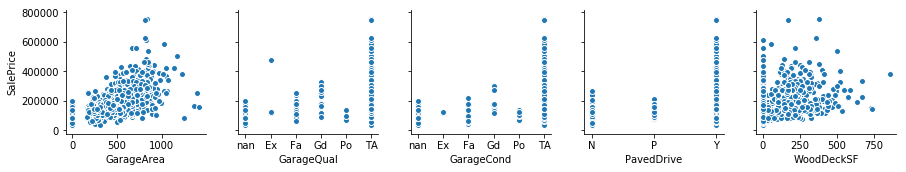

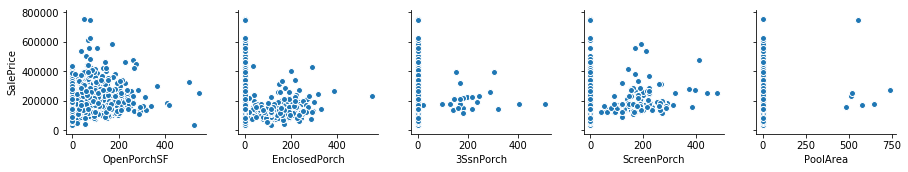

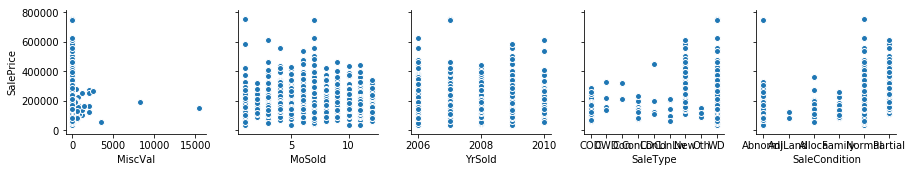

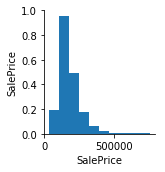

In [4]:
#Plot SalePrice in relationhip with each feature to look for outliers
for i in range(0, len(train.columns)-5, 5):
    sns.pairplot(data=train,
                x_vars=train.drop(['Alley','FireplaceQu','PoolQC','Fence','MiscFeature'],axis=1).columns[i:i+5],
                y_vars=['SalePrice'])

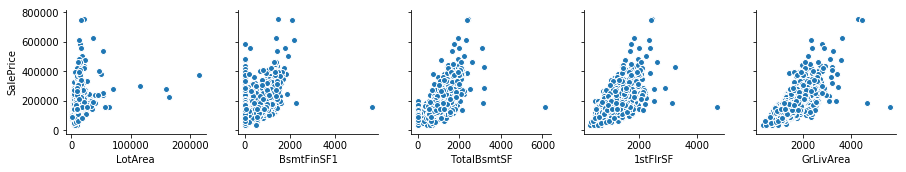

In [5]:
#extract some features that seems to contain outliers
out_col=['LotArea','BsmtFinSF1','TotalBsmtSF','1stFlrSF','GrLivArea']
sns.pairplot(data=train, x_vars=out_col, y_vars=['SalePrice'])

There are four points in LotArea graph that seem outstanding from the other points, and considering it is highly like for a house to have a lot area greater than 100000 square feet, we can safely delete the four data where LotArea is greater than 100000.

In the GrLivArea graph, there are two points in the bottom right that can be considered as outliers, we can safely delete these two points.

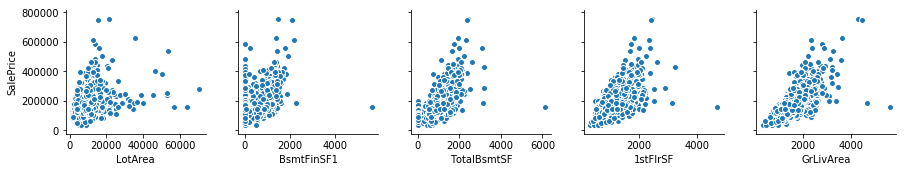

In [6]:
#drop outliers in LotArea
train.drop(train[train.LotArea > 100000].index, inplace=True)
sns.pairplot(data=train, x_vars=out_col, y_vars=['SalePrice'])

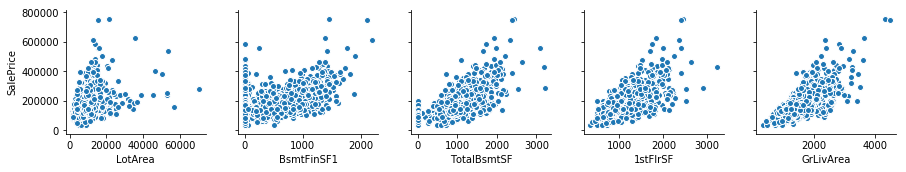

In [7]:
#drop outliers in GrLivArea
drop=train.sort_values(by = 'GrLivArea', ascending = False)[:2].index
train.drop(drop, inplace=True)
sns.pairplot(data=train, x_vars=out_col, y_vars=['SalePrice'])

## 1b. Transform Target Value

mu = 180617.09, sigma = 79299.98 and skewness = 1.89


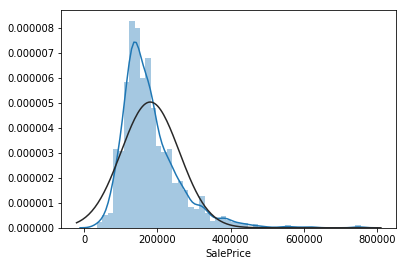

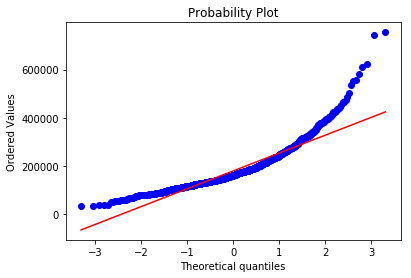

In [8]:
#see the distribution of the target value
sns.distplot(train['SalePrice'], fit=norm)
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
(mu, sigma) = norm.fit(train['SalePrice'])
print( 'mu = {:.2f}, sigma = {:.2f} and skewness = {:.2f}'.format(mu, sigma,skew(train['SalePrice'])))

SalePrice is right skewed, so I choose to apply log-transformation on target value to make it more normally distributed

mu = 12.02, sigma = 0.40 and skewness = 0.12


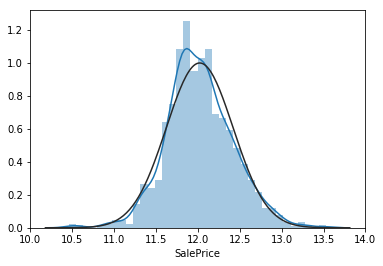

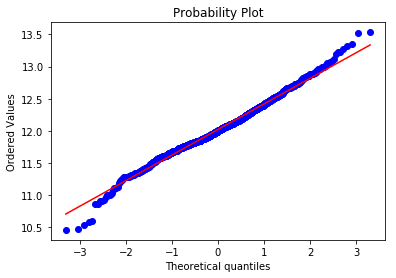

In [9]:
#log(1+x)
train['SalePrice']=np.log1p(train['SalePrice'])
sns.distplot(train['SalePrice'], fit=norm)
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
(mu, sigma) = norm.fit(train['SalePrice'])
print( 'mu = {:.2f}, sigma = {:.2f} and skewness = {:.2f}'.format(mu, sigma, skew(train['SalePrice'])))

Done!

## 1c. Missing Value

Combine training set and testing set into onedata frame

In [10]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values

#Combine into one dataframe
df = pd.concat((train, test)).reset_index(drop=True)
df.drop(['SalePrice'], axis=1, inplace=True)
print(df.shape)

(2913, 80)


In [11]:
#count the number if missing values in each feature
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(35)

,Total,Percent
PoolQC,2904,0.996910
MiscFeature,2810,0.964641
Alley,2715,0.932029
Fence,2342,0.803982
FireplaceQu,1420,0.487470
LotFrontage,483,0.165808
GarageQual,159,0.054583
GarageFinish,159,0.054583
GarageYrBlt,159,0.054583
GarageCond,159,0.054583


- **PoolQC**: NA means no pool, fill the missing values with 'None'

In [12]:
df['PoolQC']=df['PoolQC'].fillna('None')

- **MiscFeature, Alley, Fence and FireplaceQu**: same as PoolQc

In [13]:
df['MiscFeature']=df['MiscFeature'].fillna('None')
df['Alley']=df['Alley'].fillna('None')
df['Fence']=df['Fence'].fillna('None')
df['FireplaceQu']=df['FireplaceQu'].fillna('None')

- **LotFrontage:** the portion of missing vulues is greater than 15% and the relationship bewteen lot frontage and sales price is not strong, it is hard to fill in the right number for missing values, so I choose to delete the feature

In [14]:
df=df.drop('LotFrontage', axis = 1)

In [15]:
np.setdiff1d(df[df['BsmtCond'].isnull()].index,df[df['BsmtFinType1'].isnull()].index)

array([2034, 2179, 2518])

- **Garage:** All the garage features have the same number of missing values, considered as no garage

In [16]:
df['GarageCond']=df['GarageCond'].fillna('None')
df['GarageType']=df['GarageType'].fillna('None')
df['GarageFinish']=df['GarageFinish'].fillna('None')
df['GarageQual']=df['GarageQual'].fillna('None')
#GarageYrBlt has a earliest year 1900, I choose to fill in 1800 for the missing values to represent no garage
df['GarageYrBlt']=df['GarageYrBlt'].fillna(1893)

- **Basement:** Notice that Basement features have different number of missing values, other features have more missing values than BsmtFinType1

For the extra missing values in BsmtCond, and BsmtQual, I choose to replace with the category with most occurance. (TA)

For BsmtExposure, I choose to replace with 'No'

For BsmtFinType2, I choose to replace with 'Unf'

For the rest missing values, replace with 'None' (No Basement)

In [17]:
bsmt = ['BsmtExposure','BsmtFinType2','BsmtFinType1','BsmtCond','BsmtQual']

#find the row of the extra missing value in BsmtCond
bc=np.setdiff1d(df[df['BsmtCond'].isnull()].index,df[df['BsmtFinType1'].isnull()].index)
df['BsmtCond'][bc]='TA'

#BsmtQual
bq=np.setdiff1d(df[df['BsmtQual'].isnull()].index,df[df['BsmtFinType1'].isnull()].index)
df['BsmtQual'][bq]='TA'

#BsmtExposure
be=np.setdiff1d(df[df['BsmtExposure'].isnull()].index,df[df['BsmtFinType1'].isnull()].index)
df['BsmtQual'][be]='No'

#find the row of the extra missing value in BsmtFinType2
bf=np.setdiff1d(df[df['BsmtFinType2'].isnull()].index,df[df['BsmtFinType1'].isnull()].index)
df['BsmtFinType2'][bf]='Unf'

#replace missing values in basement category with 'None'
for col in bsmt:
    df[col]=df[col].fillna('None')

- **MasVnrArea and MasVnrType:** NA means no masonry veneer, replace NA in MasVnrArea with 0 and replace NA in MasVnrType with None

In [18]:
df['MasVnrArea']=df['MasVnrArea'].fillna(0)
df['MasVnrType']=df['MasVnrType'].fillna('None')

In [19]:
df['Electrical'].describe()

count      2912
unique        5
top       SBrkr
freq       2665
Name: Electrical, dtype: object

- **Electrical:** replace NA with the category with most occurrence frequency, in this case "SBrkr'

In [20]:
df['Electrical']=df['Electrical'].fillna('SBrkr')

In [21]:
#MSZoning
df['MSZoning']=df['MSZoning'].fillna('RL')

#BsmtFullBath
df['BsmtFullBath']=df['BsmtFullBath'].fillna(0)

#Utilities
df['Utilities']=df['Utilities'].fillna('AllPub')

#Functional
df['Functional'] = df['Functional'].fillna('Typ')

#BsmtHalfBath
df['BsmtHalfBath'] = df['BsmtHalfBath'].fillna(0)

#Exterior2nd
df['Exterior2nd'] = df['Exterior2nd'].fillna('VinylSd')

#BsmtUnfSF
df['BsmtUnfSF'] = df['BsmtUnfSF'].fillna(0)

#BsmtFinSF2
df['BsmtFinSF2'] = df['BsmtFinSF2'].fillna(0)

#KitchenQual
df['KitchenQual'] = df['KitchenQual'].fillna('TA')

#BsmtFinSF1
df['BsmtFinSF1'] = df['BsmtFinSF1'].fillna(0)

#SaleType
df['SaleType'] = df['SaleType'].fillna('WD')

#GarageArea
df['GarageArea'] = df['GarageArea'].fillna(0)

#TotalBsmtSF
df['TotalBsmtSF'] = df['TotalBsmtSF'].fillna(0)

#GarageCars
df['GarageCars'] = df['GarageCars'].fillna(0)

#Exterior1st
df['Exterior1st'] = df['Exterior1st'].fillna('VinylSd')

In [22]:
#chech if there is any missing value left
df.isnull().sum().max()

0

# 2. Feature Engineering

### Transform numerical data that should be categorical

In [23]:
df['MSSubClass'] = df['MSSubClass'].astype(str)

df['MoSold'] = df['MoSold'].astype(str)

df['YrSold'] = df['YrSold'].astype(str)

### Encoding some categorical features into numerical features

In [24]:
df = df.replace({'Street': {'Grvl': 1, "Pave": 2},
                 'Alley': {'None':0, 'Grvl': 1, 'Pave':2},
                 'LandSlope': {'Sev': 1, 'Mod': 2, 'Gtl': 3},
                 'ExterQual': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
                 'ExterCond': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
                 'BsmtQual': {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
                 'BsmtCond': {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
                 'BsmtExposure': {'None': 0, 'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4},
                 'BsmtFinType1': {'None': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6},
                 'BsmtFinType2': {'None': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6},
                 'HeatingQC': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
                 'CentralAir': {'N': 0, 'Y': 1},
                 'KitchenQual': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
                 'Functional': {'Sal': 1, 'Sev': 2, 'Maj1': 3, 'Maj2': 4, 'Mod': 5, 'Min1': 6, 'Min2': 7, 'Typ': 8},
                 'FireplaceQu': {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
                 'GarageFinish': {'None': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3},
                 'GarageQual': {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
                 'GarageCond': {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
                 'PavedDrive': {'N': 0, 'P': 1, 'Y': 2},
                 'PoolQC': {'None': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4},
                 'Fence': {'None': 0, 'MnWw': 1, 'GdWo': 2, 'MnPrv': 3, 'GdPrv': 4},
                 'Utilities': {'ELO': 1, 'NoSeWa': 2, 'NoSewr': 3, 'AllPub': 4}
                }
)

In [25]:
df.shape

(2913, 79)

### Create new features

In [26]:
#Total number of Bathroom
df['TotalBath'] = df['BsmtFullBath'] + 0.5*df['BsmtHalfBath'] + df['FullBath'] + 0.5*df['HalfBath']

#Total Square footage
df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']

#Total proch Square footage
df['TotalPorchSF'] = df['OpenPorchSF'] + df['EnclosedPorch'] + df['3SsnPorch'] + df['ScreenPorch']

#Overall quality
df['OverallGrade'] = df['OverallCond'] * df['OverallQual']

#Overall quality of exterior
df['ExterGrade'] = df['ExterCond'] * df['ExterQual']

#Overall quality of basement
df['BsmtGrade'] = df['BsmtCond'] * df['BsmtQual']

#Kitchen Score
df['KitchenScore'] = df['KitchenAbvGr'] * df['KitchenQual']

#Fireplace Score
df['FireplaceScore'] = df['Fireplaces'] * df['FireplaceQu']

#Garage Score
df['GarageGrade'] = df['GarageCond'] * df['GarageQual'] 

### Transfrom Skewed features

In [27]:
#Numerical and categorical features
numerical=df.select_dtypes(include=[np.number]).columns.tolist()
categorical=df.select_dtypes(include=['object']).columns.tolist()

In [28]:
skewed = df[numerical].apply(lambda x: skew(x)).sort_values(ascending=False)
#box tranformation log(1+x)
skewed = skewed[skewed > 0.75]
df[skewed.index] = np.log1p(df[skewed.index])

### Get Dummies

In [29]:
df = pd.get_dummies(df)

New training and testing sets

In [30]:
train = df[:ntrain]
test = df[ntrain:]

# 3. Model

In [31]:
from sklearn.linear_model import ElasticNet, ElasticNetCV, Lasso,  BayesianRidge, LassoLarsIC, RidgeCV, Ridge, LassoCV
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, make_scorer
from xgboost.sklearn import XGBClassifier
from pprint import pprint
import xgboost as xgb
import lightgbm as lgb

### Cross-validation strategy

In [32]:
n_folds = 10

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=40).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

### Ridge Regression

In [33]:
ridge = RidgeCV(alphas = [0.1, 1.0, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0, 20.0])
ridge.fit(train, y_train)
print('Best alpha :', ridge.alpha_)

Best alpha : 10.0


In [34]:
ridge = make_pipeline(RobustScaler(), Ridge(alpha=10.0))
ridge_score = rmsle_cv(ridge)
print('Ridge score: {:.4f} ({:.4f})'.format(ridge_score.mean(), ridge_score.std()))

Ridge score: 0.1097 (0.0140)


### Lasso Regression

In [35]:
lasso = LassoCV(alphas = [0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009, 0.001, 0.01, 0.1])
lasso.fit(train, y_train)
alpha = lasso.alpha_
print('Best alpha : ', alpha)

Best alpha :  0.0005


In [36]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha = 0.0005, random_state=1))
lasso_score = rmsle_cv(lasso)
print('Lasso score: {:.4f} ({:.4f})'.format(lasso_score.mean(), lasso_score.std()))

Lasso score: 0.1079 (0.0141)


### ElasticNet

In [38]:
ENet = ElasticNetCV(l1_ratio = [0.1, 0.3, 0.5, 0.55, 0.6, 0.65, 0.7, 0.8, 0.85, 0.9, 0.95, 1, 1.1, 1.2],
                          alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 
                                    0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6])
ENet.fit(train, y_train)
l1_ratio = ENet.l1_ratio_
alpha = ENet.alpha_
print('Best l1_ratio: ', l1_ratio)
print('Best alpha : ', alpha)

Best l1_ratio:  0.95
Best alpha :  0.0006


In [39]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0006, l1_ratio=0.95, random_state=3))
enet_score = rmsle_cv(ENet)
print('ENet score: {:.4f} ({:.4f})'.format(enet_score.mean(), enet_score.std()))

ENet score: 0.1079 (0.0141)


In [46]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
krr_score = rmsle_cv(KRR)
print('KRR score: {:.4f} ({:.4f})'.format(krr_score.mean(), krr_score.std()))

KRR score: 0.1996 (0.0212)


In [85]:
xgb_model = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

print(rmsle_cv(xgb_model).mean())

0.11354885729399644


In [83]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

print(rmsle_cv(GBoost).mean())

0.1129488866871025


In [84]:
lgb_model = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

print(rmsle_cv(lgb_model).mean())

0.11250851635451904


### Model Stacking

In [45]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)

In [86]:
averaged_models = AveragingModels(models = (ENet, ridge, lasso, xgb_model))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 0.1067 (0.0143)



In [88]:
averaged_models = AveragingModels(models = (ENet, ridge, lasso, xgb_model, GBoost))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 0.1056 (0.0148)



In [89]:
averaged_models = AveragingModels(models = (ENet, ridge, lasso, GBoost))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 0.1057 (0.0147)



In [91]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [92]:
stacked_averaged_models = StackingAveragedModels(base_models = (ridge, lasso, GBoost),
                                                 meta_model = ENet)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 0.1054 (0.0149)


In [94]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [95]:
stacked_averaged_models.fit(train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test.values))
print(rmsle(y_train, stacked_train_pred))

0.0818740420828952


In [96]:
xgb_model.fit(train, y_train)
xgb_train_pred = xgb_model.predict(train)
xgb_pred = np.expm1(xgb_model.predict(test))
print(rmsle(y_train, xgb_train_pred))

0.07781699434921296


In [97]:
lgb_model.fit(train, y_train)
lgb_train_pred = lgb_model.predict(train)
lgb_pred = np.expm1(lgb_model.predict(test.values))
print(rmsle(y_train, lgb_train_pred))

0.07142515268441502


In [99]:
ensemble = stacked_pred*0.75 + xgb_pred*0.15 + lgb_pred*0.10

In [100]:
averaged_models.fit(train, y_train)
predicted_prices = averaged_models.predict(test)
predicted_prices = np.expm1(predicted_prices)
my_submission = pd.DataFrame({'Id': test.Id, 'SalePrice': ensemble})
my_submission.to_csv('submission.csv', index=False)